# Homework 2

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

***

# 1. The ProShares ETF Product

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

## 1. Alternative ETFs

Describe the two types of investments referenced by this term.

## 2. Hedge Funds.

#### a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?

#### b. What are the main benefits of investing in hedge funds via an ETF instead of directly?

## 3. The Benchmarks

#### a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.

#### b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

#### c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)

#### d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?

## 4. The HDG Product

#### a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

#### b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

#### c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

***

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `Aug 2023`.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA
from statsmodels.regression.rolling import RollingOLS

def print(*args):
    __builtins__.print(*("%.4f" % a if isinstance(a, float) else a for a in args))
    
pd.set_option("display.precision", 5)
pd.options.display.float_format = "{:.4f}".format

def cagr(start_p,end_p,months):
    r1 = end_p/start_p
    mon_r = (r1)**(1/months)
    cagr_ret = (mon_r-1)*12
    return cagr_ret

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_proshares = pd.read_excel('proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
display(df_proshares)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
2011-08-31,-0.0321,-0.0256,-0.0257,-0.0270,-0.0065
2011-09-30,-0.0389,-0.0324,-0.0326,-0.0325,-0.0221
2011-10-31,0.0269,0.0436,0.0433,0.0505,0.0252
2011-11-30,-0.0135,-0.0121,-0.0124,-0.0286,-0.0080
2011-12-31,-0.0045,0.0019,0.0018,0.0129,0.0018
...,...,...,...,...,...
2023-04-30,0.0024,0.0009,0.0003,-0.0004,0.0051
2023-05-31,-0.0020,-0.0010,-0.0015,-0.0014,-0.0065
2023-06-30,0.0214,0.0159,0.0159,0.0167,0.0226
2023-07-31,0.0178,0.0172,0.0166,0.0137,0.0194


## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [3]:
df_perf = pd.DataFrame()

df_perf['Annual_Mean_ret'] = (df_proshares.mean())*12
df_perf['Annual_Vol'] = (df_proshares.std())*np.sqrt(12)
df_perf['Sharpe_ratio'] = df_perf['Annual_Mean_ret']/df_perf['Annual_Vol']
display(df_perf)


,Annual_Mean_ret,Annual_Vol,Sharpe_ratio
HFRIFWI Index,0.0432,0.0602,0.7177
MLEIFCTR Index,0.0319,0.0570,0.5597
MLEIFCTX Index,0.0304,0.0568,0.5351
HDG US Equity,0.0205,0.0594,0.3455
QAI US Equity,0.0196,0.0501,0.3917


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [4]:
df_perf['Skewness'] = df_proshares.skew()
df_perf['Excess_Kurtosis'] = df_proshares.kurt()-3
df_perf['VaR'] = df_proshares.quantile(0.05)
display(df_perf)

,Annual_Mean_ret,Annual_Vol,Sharpe_ratio,Skewness,Excess_Kurtosis,VaR
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,2.9183,-0.0251
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,-1.3357,-0.0287
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,-1.3684,-0.0289
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,-1.2199,-0.0312
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,-1.2624,-0.0201


In [5]:
def CVaR(df):
    arr = []
    for i in df.columns:
        var1 = df[i].quantile(0.05)
        cvar1 = df[df[i]<var1][i].mean()
        arr.append(cvar1)
    return arr

df_perf['CVaR'] = CVaR(df_proshares)
display(df_perf)

,Annual_Mean_ret,Annual_Vol,Sharpe_ratio,Skewness,Excess_Kurtosis,VaR,CVaR
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,2.9183,-0.0251,-0.0375
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,-1.3357,-0.0287,-0.0359
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,-1.3684,-0.0289,-0.0358
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,-1.2199,-0.0312,-0.0376
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,-1.2624,-0.0201,-0.0327


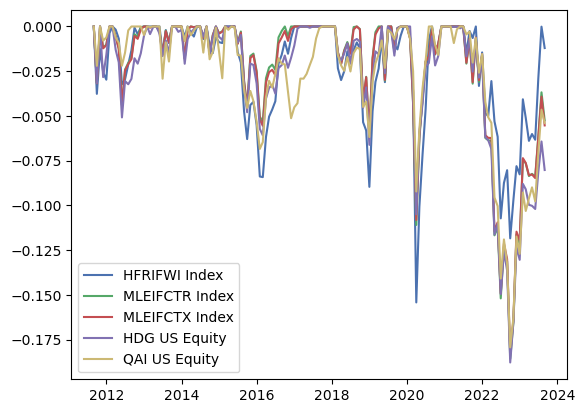

,Annual_Mean_ret,Annual_Vol,Sharpe_ratio,Skewness,Excess_Kurtosis,VaR,CVaR,Max_DD,Max_DD_dt,Recovery_dt
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,2.9183,-0.0251,-0.0375,-0.1542,2020-03-31,2020-08-31 0.0000 2020-11-30 0.0000 2020-1...
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,-1.3357,-0.0287,-0.0359,-0.1856,2022-09-30,"Series([], Name: MLEIFCTR Index, dtype: float64)"
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,-1.3684,-0.0289,-0.0358,-0.1830,2022-09-30,"Series([], Name: MLEIFCTX Index, dtype: float64)"
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,-1.2199,-0.0312,-0.0376,-0.1878,2022-09-30,"Series([], Name: HDG US Equity, dtype: float64)"
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,-1.2624,-0.0201,-0.0327,-0.1793,2022-09-30,"Series([], Name: QAI US Equity, dtype: float64)"


In [6]:
def Max_DD(df):
    arr = []
    arr2 = []
    arr3 = []
    df2 = df + 1
    df3 = df2.cumprod()
    df4 = df3 - df3.cummax()
    plt.figure()
    for i in df4.columns:
        plt.plot(df4[i],label=i)
        max_dd1 = df4[i].min()
        max_dd_dt = df4[i].idxmin()
        recov_dt = df4.loc[(df4[i]==0) & (df4.index > max_dd_dt)][i]
        arr.append(max_dd1)
        arr2.append(max_dd_dt)
        arr3.append(recov_dt)
    plt.legend()
    plt.show()
    return arr,arr2,arr3

# ----Change the maxDD formula to calculate change from the peak instead of start point

df_perf['Max_DD'],df_perf['Max_DD_dt'],df_perf['Recovery_dt'] = Max_DD(df_proshares)
display(df_perf)

In [7]:
pd.DataFrame(df_perf['Recovery_dt'][0])

,HFRIFWI Index
2020-08-31,0.0000
2020-11-30,0.0000
2020-12-31,0.0000
2021-01-31,0.0000
2021-02-28,0.0000
2021-03-31,0.0000
2021-04-30,0.0000
2021-05-31,0.0000
2021-06-30,0.0000
2021-10-31,0.0000


### The Max drawdown date is 31st March 2020 HFRIFWI index and it is 30th Sep 2022 for all other funds. The recovery for HFRIFWI happened after 5 months in Aug 2020. However, the recovery hasn't happened yet for other funds from Sep 2022 so it seems the recovery cycle is more than 1 year for them.

## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [8]:
df_merrill_factors = pd.read_excel('proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
display(df_merrill_factors)

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,-0.0550,0.0000,-0.0925,-0.0875,-0.0059,-0.0889
2011-09-30,-0.0694,0.0000,-0.1791,-0.1081,0.1422,-0.1115
2011-10-31,0.1091,-0.0000,0.1630,0.0963,-0.0695,0.1510
2011-11-30,-0.0041,0.0000,-0.0197,-0.0218,0.0546,-0.0038
2011-12-31,0.0104,0.0000,-0.0426,-0.0217,0.0756,0.0051
...,...,...,...,...,...,...
2023-04-30,0.0160,0.0042,-0.0084,0.0294,-0.0276,-0.0179
2023-05-31,0.0046,0.0045,-0.0240,-0.0401,0.0695,-0.0082
2023-06-30,0.0648,0.0044,0.0440,0.0447,-0.0361,0.0807
2023-07-31,0.0327,0.0045,0.0604,0.0270,-0.0110,0.0611


In [9]:
arr_beta = []
df_X_1 = df_merrill_factors['SPY US Equity']
df_X_1 = sm.add_constant(df_X_1)
for i in df_proshares.columns:
    model1 = sm.OLS(df_proshares[i],df_X_1)
    results1 = model1.fit()
#     print(results1.summary())
    arr_beta.append(results1.params[1])
    
df_perf['Beta_with_SPY'] = arr_beta
display(df_perf)

,Annual_Mean_ret,Annual_Vol,Sharpe_ratio,Skewness,Excess_Kurtosis,VaR,CVaR,Max_DD,Max_DD_dt,Recovery_dt,Beta_with_SPY
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,2.9183,-0.0251,-0.0375,-0.1542,2020-03-31,2020-08-31 0.0000 2020-11-30 0.0000 2020-1...,0.3487
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,-1.3357,-0.0287,-0.0359,-0.1856,2022-09-30,"Series([], Name: MLEIFCTR Index, dtype: float64)",0.3496
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,-1.3684,-0.0289,-0.0358,-0.1830,2022-09-30,"Series([], Name: MLEIFCTX Index, dtype: float64)",0.3483
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,-1.2199,-0.0312,-0.0376,-0.1878,2022-09-30,"Series([], Name: HDG US Equity, dtype: float64)",0.3594
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,-1.2624,-0.0201,-0.0327,-0.1793,2022-09-30,"Series([], Name: QAI US Equity, dtype: float64)",0.2961


In [10]:
df_perf['Treynor_ratio'] = df_perf['Annual_Mean_ret']/df_perf['Beta_with_SPY']
display(df_perf)

,Annual_Mean_ret,Annual_Vol,Sharpe_ratio,Skewness,Excess_Kurtosis,VaR,CVaR,Max_DD,Max_DD_dt,Recovery_dt,Beta_with_SPY,Treynor_ratio
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,2.9183,-0.0251,-0.0375,-0.1542,2020-03-31,2020-08-31 0.0000 2020-11-30 0.0000 2020-1...,0.3487,0.1240
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,-1.3357,-0.0287,-0.0359,-0.1856,2022-09-30,"Series([], Name: MLEIFCTR Index, dtype: float64)",0.3496,0.0912
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,-1.3684,-0.0289,-0.0358,-0.1830,2022-09-30,"Series([], Name: MLEIFCTX Index, dtype: float64)",0.3483,0.0873
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,-1.2199,-0.0312,-0.0376,-0.1878,2022-09-30,"Series([], Name: HDG US Equity, dtype: float64)",0.3594,0.0571
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,-1.2624,-0.0201,-0.0327,-0.1793,2022-09-30,"Series([], Name: QAI US Equity, dtype: float64)",0.2961,0.0662


In [11]:
arr_alpha = []
arr_std_err = []
arr_info_ratio = []
df_X_1 = df_merrill_factors['SPY US Equity']
df_X_1 = sm.add_constant(df_X_1)
for i in df_proshares.columns:
    model1 = sm.OLS(df_proshares[i],df_X_1)
    results1 = model1.fit()
    a1 = (results1.params[0])*12
    a2 = results1.bse[0]
    arr_alpha.append(a1)
    arr_std_err.append(a2)
    arr_info_ratio.append(a1/a2)
    
df_perf['Information_ratio'] = arr_info_ratio
display(df_perf)

,Annual_Mean_ret,Annual_Vol,Sharpe_ratio,Skewness,Excess_Kurtosis,VaR,CVaR,Max_DD,Max_DD_dt,Recovery_dt,Beta_with_SPY,Treynor_ratio,Information_ratio
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,2.9183,-0.0251,-0.0375,-0.1542,2020-03-31,2020-08-31 0.0000 2020-11-30 0.0000 2020-1...,0.3487,0.1240,-4.0399
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,-1.3357,-0.0287,-0.0359,-0.1856,2022-09-30,"Series([], Name: MLEIFCTR Index, dtype: float64)",0.3496,0.0912,-23.3198
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,-1.3684,-0.0289,-0.0358,-0.1830,2022-09-30,"Series([], Name: MLEIFCTX Index, dtype: float64)",0.3483,0.0873,-25.3814
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,-1.2199,-0.0312,-0.0376,-0.1878,2022-09-30,"Series([], Name: HDG US Equity, dtype: float64)",0.3594,0.0571,-39.5402
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,-1.2624,-0.0201,-0.0327,-0.1793,2022-09-30,"Series([], Name: QAI US Equity, dtype: float64)",0.2961,0.0662,-31.5243


In [12]:
# -----Use these for standard errors------------------

# print(results1.params[0])

# print(np.sqrt(np.sum(results1.resid**2)/results1.df_resid))

# print(np.sqrt(results1.mse_resid))

## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

### The sharpe ratio of HFRIFWI Index is highest among the hedge funds. Only this fund is Leptokurtic, whereas all others are Platykurtic. So, this fund had fatter tails in comparison to all other funds.
### CVaR and VaR values are lowest for QAI US Equity which tells us that worst case probable losses were lower in this fund.
### In terms of regression Beta values with SPY US equity - QAI US Equity has the lowest beta and others have very similar values. This means the movement of SPY has lowest effect on QAI US hedge fund. 
### The Treynor's ratio tells us that HFRIFWI Index	Hedge fund provides best returns with respect to beta value.
### None of these funds provide a positive alpha and as a result information ratio values are negative. 

## Comparing HDG and QAI:

### Sharpe ratio, VaR, CVaR, Treynor ratio and beta values are better for QAI.

## Comparing HFRI with HDG and ML Series:

### It seems that Beta values for all these are quite similar but no other statistics. However, based on Treynor and sharpe ratio HFRI outperforms these funds.

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

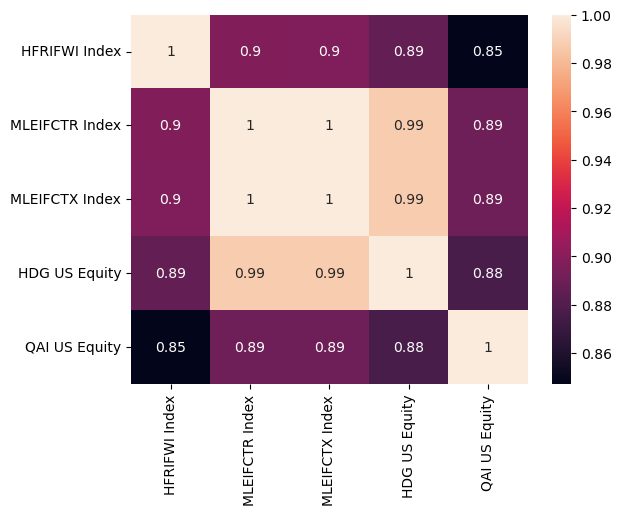

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.heatmap(df_proshares.corr(),annot=True)
plt.show()

### All of these have really high correlations with each other and it seems ML series (MLEIFCTR Index, MLEIFCTX Index) are having the highest correlations. 
### The lowest correlation value is 85% which is attributed to HFRIFWI Index and QAI US Equity.

## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

#### a. Report the intercept and betas.
#### b. Are the betas realistic position sizes, or do they require huge long-short positions?
#### c. Report the R-squared.
#### d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [14]:
df_X_merrill = df_merrill_factors
df_X_merrill = sm.add_constant(df_X_merrill)
# display(df_X_merrill)
model1 = sm.OLS(df_proshares['HFRIFWI Index'],df_X_merrill)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:          HFRIFWI Index   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     118.0
Date:                Mon, 16 Oct 2023   Prob (F-statistic):           7.98e-52
Time:                        15:01:43   Log-Likelihood:                 513.78
No. Observations:                 145   AIC:                            -1014.
Df Residuals:                     138   BIC:                            -992.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.815

In [15]:
# ----------Intercept and betas-----------------
print(results1.params)

const            0.0014
SPY US Equity    0.0333
USGG3M Index    -0.1659
EEM US Equity    0.0779
EFA US Equity    0.0824
EUO US Equity    0.0226
IWM US Equity    0.1521
dtype: float64


### No they don't require huge long-short positions. The beta values seem to be in range.
### Although, the p-values for USGG3M and SPY US Equity might suggest that beta values for these are not significantly different from zero statistically.   

In [16]:
print('R-Squared value:',results1.rsquared)
print('Adjusted R-Squared value:',results1.rsquared_adj)

R-Squared value: 0.8369
Adjusted R-Squared value: 0.8298


In [17]:
print('The tracking error from regression:',results1.bse['const'])
print(np.sqrt(results1.bse['const']))

print(results1.resid.std())

The tracking error from regression: 0.0008
0.0276
0.0070


## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [18]:
oos_ret_arr = pd.DataFrame(index=df_merrill_factors.index)
oos_ret_arr['OOS_Ret'] = np.zeros(df_merrill_factors.shape[0])
for i in range(len(df_merrill_factors)-60):
    X_reg = df_merrill_factors.iloc[i:i+60,]
    X_reg = sm.add_constant(X_reg)
    Y_reg = df_proshares['HFRIFWI Index'][i:i+60]
    model2 = sm.OLS(Y_reg,X_reg)
    results2 = model2.fit()
    oos_ret_arr.iloc[i+60,] = (np.array(results2.params[1:]).dot(np.array(df_merrill_factors.iloc[i+60,]))) + (results2.params[0])
    
display(oos_ret_arr)    

,OOS_Ret
2011-08-31,0.0000
2011-09-30,0.0000
2011-10-31,0.0000
2011-11-30,0.0000
2011-12-31,0.0000
...,...
2023-04-30,-0.0060
2023-05-31,-0.0082
2023-06-30,0.0227
2023-07-31,0.0195


In [37]:
Y1 = df_proshares['HFRIFWI Index']
X_rolling = df_merrill_factors
X_rolling = sm.add_constant(X_rolling)

results_rolling = RollingOLS(Y1,X_rolling,window=60)
results_rolling_res = results_rolling.fit()
display(results_rolling_res.params)
display(results_rolling_res.fittedvalues)
display(results_rolling_res.params.iloc[58,])


,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-04-30,0.0046,-0.0481,-1.3107,0.0797,0.0562,-0.0079,0.2446
2023-05-31,0.0043,-0.0410,-1.0515,0.0841,0.0422,-0.0022,0.2478
2023-06-30,0.0044,-0.0413,-1.0804,0.0817,0.0425,-0.0031,0.2487
2023-07-31,0.0045,-0.0384,-1.1190,0.0826,0.0444,-0.0012,0.2451


AttributeError: 'RollingRegressionResults' object has no attribute 'fittedvalues'

,OOS_Ret,Insample_ret,HFRIFWI Index
2016-08-31,1.0050,1.0053,1.0043
2016-09-30,1.0100,1.0111,1.0108
2016-10-31,1.0055,1.0034,1.0048
2016-11-30,1.0172,1.0196,1.0125
2016-12-31,1.0250,1.0285,1.0226
...,...,...,...
2023-04-30,1.2795,1.3216,1.3995
2023-05-31,1.2689,1.3163,1.3967
2023-06-30,1.2977,1.3444,1.4266
2023-07-31,1.3231,1.3682,1.4519


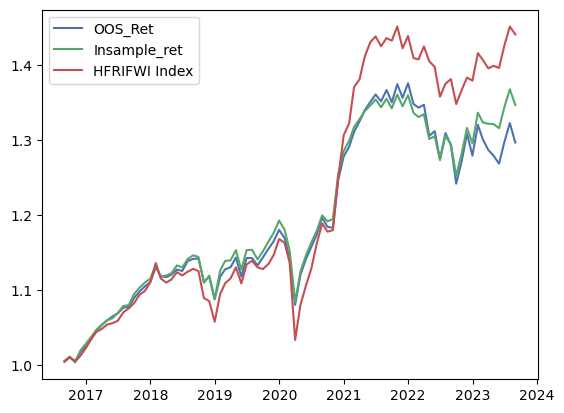

In [19]:
X_mult = df_X_merrill
ret_insample = X_mult.dot(np.array(results1.params))
oos_ret_arr['Insample_ret'] = ret_insample
oos_ret_arr['HFRIFWI Index'] = df_proshares['HFRIFWI Index']
# display(oos_ret_arr)

oos_ret_compare = oos_ret_arr.iloc[60:,]
oos_ret_compare = oos_ret_compare + 1 
oos_ret_compare = oos_ret_compare.cumprod()
display(oos_ret_compare)

plt.figure()
for col in oos_ret_compare.columns:
    plt.plot(oos_ret_compare[col],label=col)
    
plt.legend()
plt.show()

## 8.

We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [20]:
df_X_merrill2 = df_merrill_factors
# display(df_X_merrill)
model3 = sm.OLS(df_proshares['HFRIFWI Index'],df_X_merrill2)
results3 = model3.fit()
print(results3.summary())

                                 OLS Regression Results                                
Dep. Variable:          HFRIFWI Index   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                              121.6
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                    8.97e-53
Time:                        15:01:43   Log-Likelihood:                          512.07
No. Observations:                 145   AIC:                                     -1012.
Df Residuals:                     139   BIC:                                     -994.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [21]:
print('----Regression with intercept----------')
display(results1.params)
print('----Regression without intercept----------')
display(results3.params)


----Regression with intercept----------


const            0.0014
SPY US Equity    0.0333
USGG3M Index    -0.1659
EEM US Equity    0.0779
EFA US Equity    0.0824
EUO US Equity    0.0226
IWM US Equity    0.1521
dtype: float64

----Regression without intercept----------


SPY US Equity   0.0509
USGG3M Index    0.3378
EEM US Equity   0.0776
EFA US Equity   0.0753
EUO US Equity   0.0256
IWM US Equity   0.1486
dtype: float64

### There is a significant difference between coefficients for USGG3M Index among the merrill factors. 

In [22]:
print('Mean of fitted values without intercept is:', results3.fittedvalues.mean())
print('Mean of fitted values with intercept is:', results1.fittedvalues.mean())
print('Mean of actual HFRI Data:', df_proshares['HFRIFWI Index'].mean())

Mean of fitted values without intercept is: 0.0028
Mean of fitted values with intercept is: 0.0036
Mean of actual HFRI Data: 0.0036


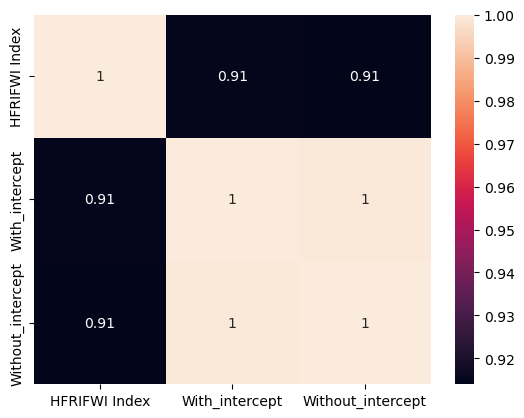

In [23]:
df_corr_reg = pd.DataFrame()
df_corr_reg['HFRIFWI Index'] = df_proshares['HFRIFWI Index'] 
df_corr_reg['With_intercept'] = results1.fittedvalues
df_corr_reg['Without_intercept'] = results3.fittedvalues

plt.figure()
sns.heatmap(df_corr_reg.corr(),annot=True)
plt.show()

### The values for both regressions are correlated perfectly with each other and at 91% correlation with the actual data. However, the mean value align with the actual data better with an intercept.
### Also the p-values seem to have improved in the regression without intercept.

***

# 3.  Extensions
<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

***